# Model Evaluation, Cross-Validation, and Hyperparameter Tuning 

This file explores the initial performance of several machine learning models and conducts additional tests to improve model predictions. 

In [53]:
import warnings # ignore those warnings!

# general use packages
import matplotlib.pyplot as plt # visualization
from datetime import date # ensure out date column is indeed a data column
import seaborn as sns # more viz
import numpy as np # basic munging
import pandas as pd # data management

# model packages
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit



# model assessment
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix

warnings.filterwarnings('ignore')

# %run Boston_311_Master_Merger.ipynb

master = pd.read_csv("~/Documents/Georgetown SCS/capstone/boston-311/01 data/master.csv")

## Encoding

We're going to try two different encoding approaches:
1. One-hot encoding for our main string features of interest (source of 311 call and reason for 311 call) to widen our data frame and turn each string into its own 0/1 column
2. Ordinal encoding of string variables, which will keep our feature space the same, but ensure we are only dealing with numeric data

In [4]:
master.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1864760 entries, 0 to 1864759
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   case_enquiry_id  int64  
 1   date             object 
 2   ontime           object 
 3   case_status      object 
 4   subject          object 
 5   reason           object 
 6   avgprcp          float64
 7   Total_P1         float64
 8   GEOID20          float64
 9   ucr_one          float64
 10  ucr_two          float64
 11  total_ucr        float64
dtypes: float64(6), int64(1), object(5)
memory usage: 170.7+ MB


In [54]:
master.isna().sum()

case_enquiry_id         0
date                    0
ontime                128
case_status             0
subject                 0
reason                  0
avgprcp            272537
Total_P1               79
GEOID20                79
ucr_one                79
ucr_two                79
total_ucr              79
dtype: int64

In [ ]:
# we have a lot of missing rainfall values, let's impute them

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2, weights="uniform")

imputer.fit(master['avgprcp'].values.reshape(-1, 1))
master['avgprcp'] = imputer.transform(master['avgprcp'].values.reshape(-1, 1))

KeyboardInterrupt: 

In [ ]:
master.isna().sum()

In [5]:
# let's split out our date columns

# first ensure our date column is indeed a date column
master['date'] = pd.to_datetime(master['date'])

# Breakout day, month, and year from the date field
master['day'] = master['date'].dt.day
master['month'] = master['date'].dt.month
master['year'] = master['date'].dt.year

# let's also ensure we only have numeric values

master['Total_P1'] = pd.to_numeric(master.Total_P1, errors='coerce')

master['GEOID20'] = pd.to_numeric(master.GEOID20, errors='coerce')


## Select the fields that will potentially be used for further feature selection and later modeling

In [6]:
# Define the fields we will use for ML
cols = ['case_enquiry_id','date','ontime','case_status','subject','reason','avgprcp','Total_P1','GEOID20','ucr_one','ucr_two','total_ucr']
master = master[cols]

In [7]:
## Encoding

In [8]:
# One-hot encode categorical features
master_one_hot= pd.get_dummies(data=master, columns=['reason', 'subject', 'ontime'])

master_one_hot['closed'] = master_one_hot['case_status'].apply(lambda x: 1 if x=='Closed' else 0)

master_one_hot = master_one_hot.drop('case_status', axis=1)

master_one_hot.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1864760 entries, 0 to 1864759
Data columns (total 75 columns):
 #   Column                                     Dtype         
---  ------                                     -----         
 0   case_enquiry_id                            int64         
 1   date                                       datetime64[ns]
 2   avgprcp                                    float64       
 3   Total_P1                                   float64       
 4   GEOID20                                    float64       
 5   ucr_one                                    float64       
 6   ucr_two                                    float64       
 7   total_ucr                                  float64       
 8   reason_Abandoned Bicycle                   uint8         
 9   reason_Administrative                      uint8         
 10  reason_Administrative & General Requests   uint8         
 11  reason_Air Pollution Control               uint8         
 12  

In [9]:
# create simple numeric columns

# there is definitely an easier way to do this, but it didn't work when I combined these into a function
master_numeric = master
master_numeric['reason'] = pd.factorize(master_numeric['reason'])[0]
master_numeric['subject'] = pd.factorize(master_numeric['subject'])[0]
master_numeric['ontime'] = pd.factorize(master_numeric['ontime'])[0]



In [10]:
master_numeric.head()

,case_enquiry_id,date,ontime,case_status,subject,reason,avgprcp,Total_P1,GEOID20,ucr_one,ucr_two,total_ucr
0,101001409422,2015-06-15,0,Closed,0,0,102.0,2120.0,2.502511e+11,101.0,436.0,537.0
1,101001409423,2015-06-15,0,Open,1,1,102.0,1033.0,2.502510e+11,83.0,294.0,377.0
2,101001409424,2015-06-15,1,Open,0,2,102.0,1872.0,2.502512e+11,116.0,444.0,560.0
3,101001409425,2015-06-15,1,Closed,0,2,102.0,610.0,2.502507e+11,617.0,1644.0,2261.0
4,101001409429,2015-06-15,0,Open,1,1,102.0,1354.0,2.502509e+11,156.0,620.0,776.0


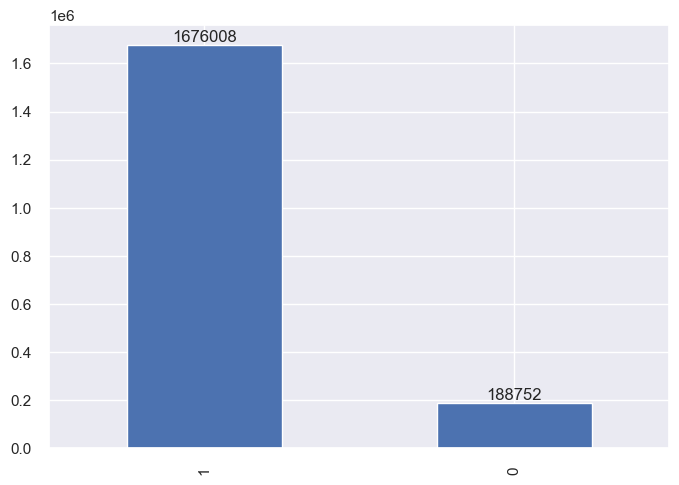

In [11]:
# we clearly have class imbalance
%matplotlib inline

sns.set_theme(style="darkgrid")

status_count_fig = master_one_hot['closed'].value_counts().plot(kind='bar')
status_count_fig.bar_label(status_count_fig.containers[0], fmt='%d' );



In [12]:
# let's rebalance with undersampling

closed=master_one_hot[master_one_hot.closed==1]
open=master_one_hot[master_one_hot.closed==0]

# upsample minority
open_upsampled = resample(open
                            , replace=True # sample with replacement 
                            , n_samples=len(closed) # match number in majority class
                          , random_state=12022022) # set seed

# combine majority and upsampled minority
upsampled = pd.concat([closed, open_upsampled])

# check new class counts
upsampled.closed.value_counts()

1    1676008
0    1676008
Name: closed, dtype: int64

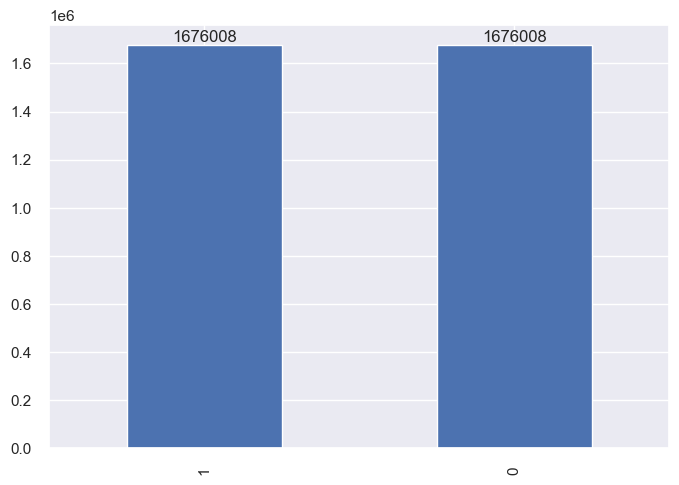

In [13]:
# now let's check our balance
status_count_fig = upsampled['closed'].value_counts().plot(kind='bar')
status_count_fig.bar_label(status_count_fig.containers[0], fmt='%d' );



In [48]:
# Prepare data for modeling

import datetime as dt


X = upsampled.drop('closed', axis=1)
X = X.drop('avgprcp', axis = 1)
X = X.drop('case_enquiry_id', axis = 1)
X['date']=X['date'].map(dt.datetime.toordinal)

y = upsampled['closed']



#### test, train split


In [49]:
tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
     

In [50]:

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))


    

In [ ]:
def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, 
        classes=['Closed', 'Open'], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20)
    
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.show()  

for model in models:
    visualize_model(X, y, model)


In [32]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

model = Lasso() # what does alpha default to? What happens when you change it?
#model.fit(X, y)


In [33]:
model

Lasso()

In [52]:
X.isna().sum()

date                                           0
Total_P1                                     146
GEOID20                                      146
ucr_one                                      146
ucr_two                                      146
                                            ... 
subject_Property Management                    0
subject_Public Works Department                0
subject_Transportation - Traffic Division      0
ontime_ONTIME                                  0
ontime_OVERDUE                                 0
Length: 72, dtype: int64